In [1]:
import ROOT
import rootpy
from rootpy.tree import Tree
import rootpy.plotting as plt
from rootpy.plotting import Hist, Hist2D, HistStack, Legend, Canvas
from rootpy.io import root_open
import pandas as pd
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)


Welcome to JupyROOT 6.10/09


In [3]:
f = root_open('/fdata/hepx/store/user/delgado_andrea/Zprime94XNtuples/m500/Zprime_m500_dbs075gb1.root','r+')
t = f.tree

In [4]:
data = []
for event in t:
    for jet in range(0,event.nJet):
        if event.Jet_pt[jet] < 30 or abs(event.Jet_eta[jet]) > 2.4: continue
        data.append([
            event.Jet_eta[jet],
            event.Jet_pt[jet],
            event.Jet_btagDeepCSVb[jet]+event.Jet_btagDeepCSVbb[jet],
            abs(event.Jet_hadronFlavour[jet]),
        ]
        )

In [5]:
data = pd.DataFrame(data, columns=['eta', 'pt', 'deepCSV', 'flavour'])

In [6]:
data.head()

,eta,pt,deepCSV,flavour
0,0.359479,163.940338,0.110240,0
1,0.264009,145.849289,0.999991,5
2,0.701838,75.272156,0.486935,5
3,-0.468025,65.619675,0.026871,5
4,1.138852,226.085587,0.831219,5


In [7]:
data.iloc[0]

eta          0.359479
pt         163.940338
deepCSV      0.110240
flavour      0.000000
Name: 0, dtype: float64

In [8]:
thresholds = {
        'L' : 0.2219,
        'M' : 0.6324,
        'T' : 0.8958
}

pt_binning = [20,30,50,70,100,140,200,300,600,1000]
efficiencies = {}


In [9]:
#define histograms, and a bit of cosmetics 
for flavour, color in zip([5, 4, 0], ['red', 'green', 'blue']):
    efficiencies[flavour] = {}
    for algo in (['deepCSV']):
        efficiencies[flavour][algo] = {}
        for wp in ['L', 'M', 'T']:
            efficiencies[flavour][algo][wp] = plt.Hist(pt_binning)
            efficiencies[flavour][algo][wp].markercolor = color
            efficiencies[flavour][algo][wp].markerstyle = 20
            efficiencies[flavour][algo][wp].title = 'Fl%d_WP%s' % (flavour, wp)
            efficiencies[flavour][algo][wp].name = 'Fl%d_WP%s' % (flavour, wp)


        

In [10]:
for flavour in efficiencies:
    jets = data[data.flavour==flavour]#FIXME select only one type of jet flavour
    for algo in efficiencies[flavour]:
        for wp in efficiencies[flavour][algo]:
            histo = efficiencies[flavour][algo][wp]
            thr = thresholds[wp]
            for hbin in histo: #Loop over histogram bins
                if hbin.overflow: continue #skip under/overflow bins
                #select jets within a pt bin: you can combine the cuts with the bit-wise
                pt_cut = (jets.pt>=hbin.x.low) & (jets.pt<hbin.x.high) #FIXME
                selJets_pt_cut = jets[pt_cut] #FIXME
                #now calculate efficiency
                #numerator: selJets with b-tag discriminator > thr
                nNu = (selJets_pt_cut[algo] > thr).sum()#FIXME
                #denominator: all selJets
                nDe = selJets_pt_cut.shape[0] #FIXME
                if nDe>0: hbin.value = float(nNu)/nDe
                else: hbin.value = 0

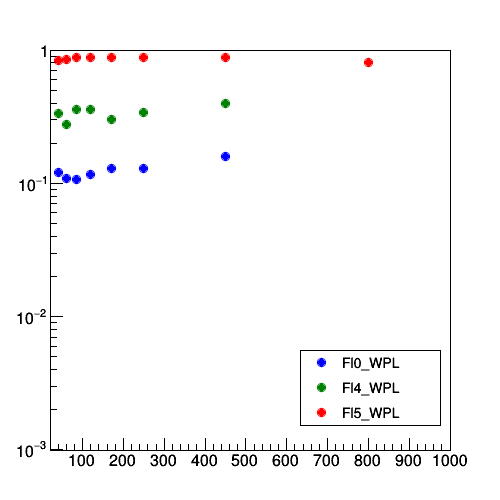

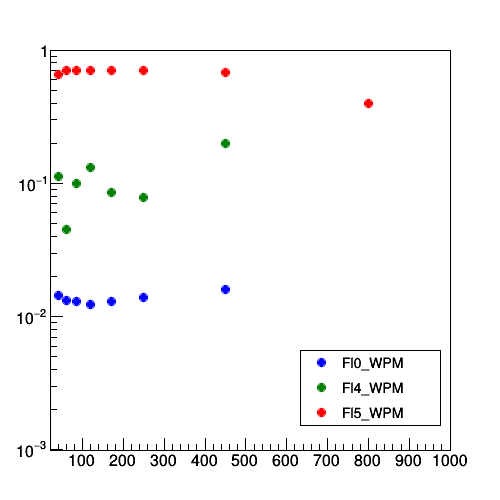

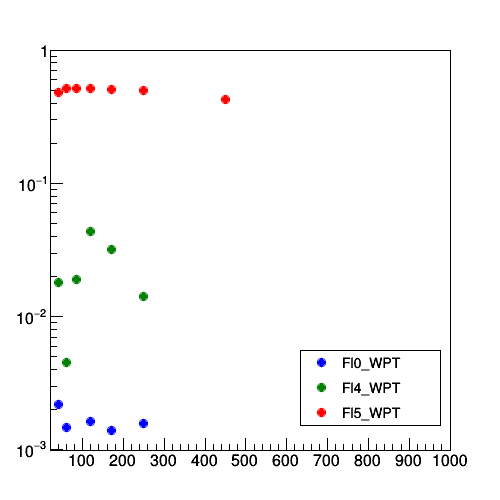

In [11]:
keep = [] #we just need this to avoid ROOT to mess-up with python
for wp in 'LMT':
    canvas = plt.Canvas(500, 500)
    canvas.SetLogy()
    legend = plt.Legend(3, entrysep=0.00, rightmargin=0.02, entryheight=0.05, textsize=0.03, topmargin=0.6)
    first = True
    for flavour in efficiencies:
        for algo in efficiencies[flavour]:
            efficiencies[flavour][algo][wp].yaxis.range_user = (0.001,1)
            efficiencies[flavour][algo][wp].Draw('p' if first else 'p same')            
            first = False
            #if flavour == 5: #do not overcrowd the legend
            legend.AddEntry(efficiencies[flavour][algo][wp])
    legend.Draw()
    canvas.Draw()
    keep.extend([legend, canvas])
        
        

In [12]:
with root_open('Deep_CSV_MCeff_Zprime_m500_dbs075gb1.root', 'update') as f:
    print(f)
    
    # Write histograms
    for flavour in efficiencies:
            for wp in efficiencies[flavour]['deepCSV']:
                efficiencies[flavour]['deepCSV'][wp].Write()


File('Deep_CSV_MCeff_Zprime_m500_dbs075gb1.root')


# ROC Curves

In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as pyplt
from sklearn.metrics import roc_curve

In [13]:
data['isB'] = (data.flavour == 5)
data.head()

,eta,pt,deepCSV,flavour,isB
0,-1.769600,187.609192,0.313023,5,True
1,0.470827,141.194214,0.656899,5,True
2,0.588496,145.702942,0.909096,5,True
3,-0.124793,108.464775,0.977244,5,True
4,0.854359,107.536766,0.897764,5,True


In [14]:
data[np.isnan(data.deepCSV)] = 0

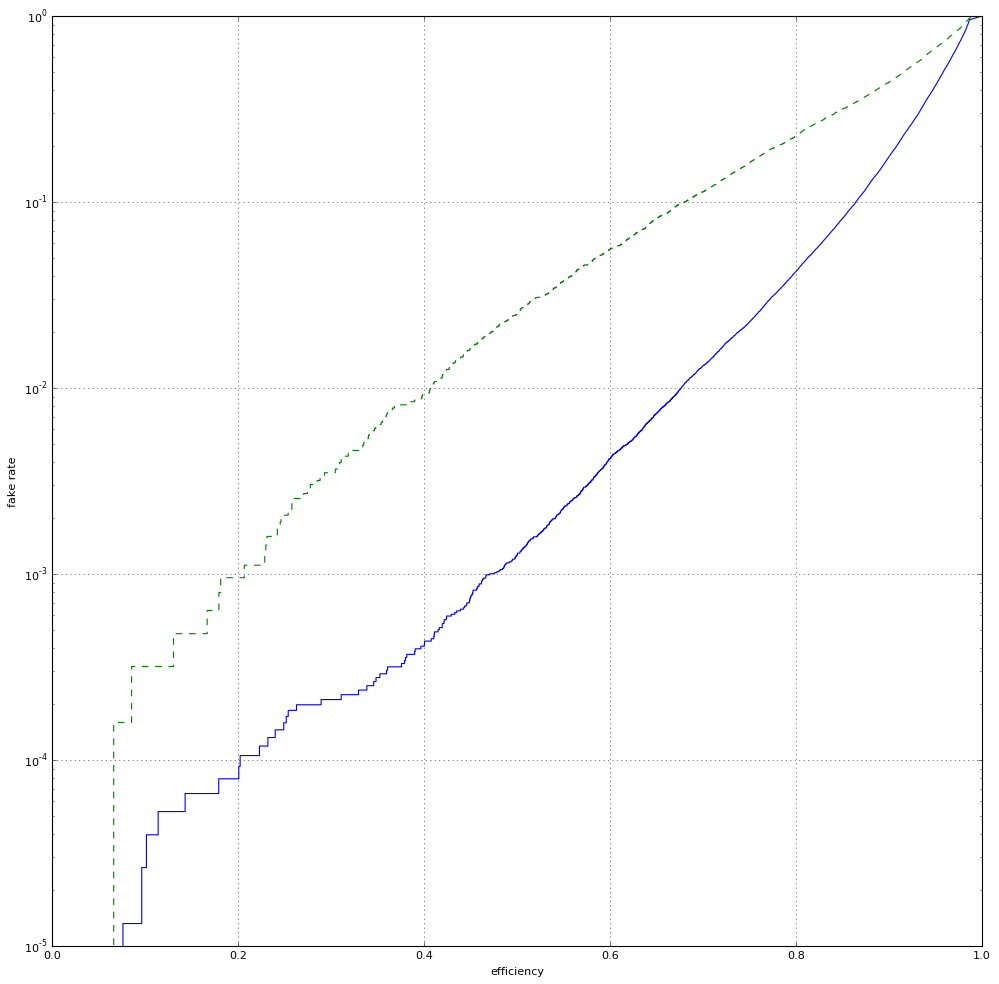

In [15]:
fig = pyplt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
#for algo, color in zip(['CSVv2', 'deepCSV', 'deepFlavour'], 'rgb'):    
for bkg, style in zip([4, 0], ['-', '--']): #- solid line -- dash line
    mask = (data.flavour != bkg)
    jets = data[mask]
    fakes_positive_rate, true_positive_rate, _ = roc_curve(jets.isB, jets['deepCSV'])
    pyplt.plot(true_positive_rate, fakes_positive_rate, '%s' % (style))

pyplt.xlabel('efficiency')
pyplt.ylabel('fake rate')
pyplt.grid(True)
pyplt.yscale('log', nonposy='clip')
pyplt.show()